In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# LLC converter design

In [196]:
Vin = {'nom':300,
       'min':270,
       'max':330} # input voltage range standard 18-36 VDC bus
Vout = {'nom':28,
        'min':27,
        'max':29} # output voltage 400V


hb = 1 # half bridge config

In [197]:
Mg={}
Vf = 0.7
Vloss = 0.5
if hb:
    bg = 0.5 # half bridge gain
else:
    bg = 1 # fullbridge gain
    
Mnom = 1.1
n = Mnom*Vin['nom']*bg/(Vout['nom']) # assume a resonant gain of 1 nominal
Mg['min']=Mnom*n*(Vout['min']+Vf)/(Vin['max']*bg)
Mg['max'] = Mnom*n*(Vout['max']+Vf+Vloss)/(Vin['min']*bg)
print(n)
print(Mg)

5.892857142857143
{'min': 1.0882142857142858, 'max': 1.450079365079365}


$$
R_{ac} = \frac{8}{\pi^2}N^2R_{load}
$$

In [199]:
Pout = 250.0 # output power in W
Iout = {}
Iout['nom'] = Pout/Vout['nom'] # nominal output current
Re = Vout['nom']/Iout['nom'] # nominal output resistance
Rac = 8*n**2*Re/(np.pi**2)

print('Re: {}'.format(Re))
print('Rac: {}'.format(Rac))

Re: 3.136
Rac: 88.27101518920469


$$ 
f_{r} = \frac{1}{2\pi\sqrt{L_{r}C_{r}}},
f_{n} = \frac{f_{sw}}{f_{r}},
L_{n} = \frac{L_{m}}{L_{r}},
Q_{e} = \frac{\sqrt{L_{r}/C_{r}}}{R_{l}}$$ 
<br/>
<br/>
$$
M = \left|\frac{L_{n}*f_{n}^{2}}{((L_{n}+1)*f_{n}^{2}-1)+j*((f_{n}^{2}-1)*f_{n}*Q_{e}*L_{n})}\right| 
$$

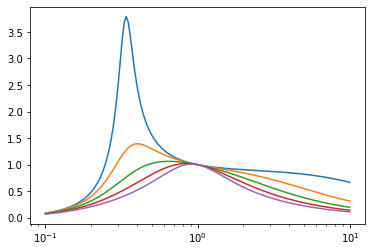

In [140]:
def mge(fn,Qe,Ln):
    # returns the gain of the resonant network given
    # fn : normalized switching frequency fsw/fres
    # Qe : quality factor sqrt(LrCr)/Rac
    # Ln : ratio between resonant inductance and magnetizing inductance Lr/Lm
    return np.abs((Ln*fn**2)/(((Ln+1)*fn**2-1)+1j*((fn**2-1)*fn*Qe*Ln)))

fn = np.arange(0.1,10,0.01)
Lm,Lr,Cr = 1e-3,1e-4,1e-9
fr = 1/(2*np.pi*np.sqrt(Lr*Cr))
Ln = Lm/Lr
Qe = np.sqrt(Lr/Cr)/Re
M1 = mge(fn,0.2,10)

for x in np.arange(0.1,1,0.2):
    M = mge(fn,x,8)
    plt.semilogx(fn,M)



$$
Q_{max}Rac = \sqrt{\frac{L_{r}}{C_{r}}}
$$
<br/>
$$
C_{r} = \frac{1}{(f_{r}2pi)^2L_{r}}
$$

In [200]:
# design procedure
# design around a resonant frequency
fr = 250.0e3
# Pick a Qmax probably between 0.1 and 1
Qmax = 0.7
# pick an Ln value
Ln = 10
# find minimum normalized switching frequency, peak of curve
M = mge(fn,Qmax,Ln)
Mm = np.max(M)
idx = 0
while Mm-Mg['max'] < 0.1: # tune Ln until within +/- 0.1 of desired
    if Mm < Mg['max']: # if max achievable is less than required max, increase Ln
        Ln = Ln-0.1
    else: # else decrease Ln
        Ln = Ln+0.1 
    Mm = np.max(mge(fn,Qmax,Ln))
    idx = idx + 1
    if idx > 1000:
        print('iteration limit reached')
        break

print('M: {}'.format(Mm))
print('M desired: {}'.format(Mg['max']))
print('Ln: {}'.format(Ln))

def LLC(fr,Qe,Ln,Rac):
    Lr = (Qe*Rac)/(2*np.pi*fr)
    Cr = 1/((fr*2*np.pi)**2*Lr)
    Lm = Lr*Ln
    
    return Lr,Lm,Cr

Lr,Lm,Cr = LLC(fr,Qmax,Ln,Rac)

print('Lr: {}'.format(Lr*1e6))
print('Lm: {}'.format(Lm*1e6))
print('Cr: {}'.format(Cr*1e6))


iteration limit reached
M: 1.4796810902128132
M desired: 1.450079365079365
Ln: 1.9000000000000195
Lr: 39.336551517484764
Lm: 74.7394478832218
Cr: 0.010303006210120008


In [55]:
Rac

0.3177432319023713